In [1]:
from datasets import load_dataset
import requests
import pandas as pd
import openai
import os
from dotenv import load_dotenv
import re
import base64
from PIL import Image
import matplotlib.pyplot as plt
import hashlib
import json
from tqdm import tqdm
import numpy as np
from tenacity import retry, wait_exponential, stop_after_attempt
import ast
from pathlib import Path
from rapidfuzz import fuzz, process
tqdm.pandas()

# 1. Get objects with associated colors from Visual Counterfact

In [4]:
# Use Visual Counterfact dataset to get 493 objects with associated colors
obj_color_df = load_dataset("mgolov/Visual-Counterfact")
obj_color_df = obj_color_df["color"].to_pandas()

In [5]:
display(obj_color_df)

,correct_answer,incorrect_answer,object,original_image,counterfact_image
0,['green'],brown,American chameleon,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
1,['white'],orange,Arctic fox,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
2,"['brown', 'white']",purple,Band Aid,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
3,"['brown', 'black']",green,Chesapeake Bay retriever,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
4,"['red', 'white', 'green']",brown,Christmas stocking,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
...,...,...,...,...,...
488,['silver'],orange,wrench,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
489,"['orange', 'yellow']",green,yam,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
490,['yellow'],pink,yellow lady's slipper,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
491,['white'],orange,yurt,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x03\x02\...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...


# 2. Query Google Custom Search Engine API for outline images

## 2.1. API Call

In [2]:
WORK = Path(os.environ.get("WORK", Path.cwd()))
print("WORK:", WORK)

WORK: /mnt/lustre/work/eickhoff/esx061


In [3]:
# Google API key and Search Engine CX ID
os.chdir(WORK / "color-concept-entanglement")
load_dotenv()
API_KEY = os.environ["GOOGLE_API_KEY"]  # Replace with your API Key
CX_ID = os.environ["GOOGLE_CSE_ID"]  # Your CX ID from the script

In [4]:
# Create a folder to store downloaded images
data_folder = WORK / "color-concept-entanglement" / "data"

name = "raw_images"
sample_csv = f"{name}.csv"

image_folder = os.path.join(data_folder, name)
csv_path = os.path.join(data_folder, sample_csv)
os.makedirs(image_folder, exist_ok=True)

expanded_path = os.path.join(data_folder, "expanded_images.csv")
norm_images_folder = os.path.join(data_folder, f"norm_{name}")
os.makedirs(norm_images_folder, exist_ok=True)

ranked_path = os.path.join(data_folder, "gpt_ranked_images.csv")

checkpoint_path = os.path.join(data_folder, "gpt_ranked_checked.pkl")

In [5]:
def safe_filename(object_name, url, idx):
    safe_name = object_name.replace(" ", "_").replace("/", "_")
    url_hash = hashlib.md5(url.encode()).hexdigest()[:8]  # short hash
    return f"{safe_name}_{idx}_{url_hash}.jpg"

In [ ]:
def fetch_and_download_images(object_name, num_results=5):
    query = f"a black and white outline drawing of a {object_name}"

    params = {
        "q": query,
        "cx": CX_ID,
        "key": API_KEY,
        "searchType": "image",
        "num": num_results,
        # "rights": "cc_publicdomain|cc_attribute",
        "imgType": "lineart",
        "imgDominantColor": "white",
    }

    BASE_URL = "https://www.googleapis.com/customsearch/v1"
    blocked_domains = [
        "svgsilh.com", "vecteezy.com", "creativefabrica.com",
        "creativemeadow.com", "supercoloring.com", "ohioline.osu.edu",
        "researchgate.net", "tiktok.com"
    ]

    kept_urls, image_paths = [], []
    headers = {"User-Agent": "Mozilla/5.0 (compatible; ImageFetcher/1.0)"}

    try:
        resp = requests.get(BASE_URL, params=params, timeout=20)
        resp.raise_for_status()
        data = resp.json()
        items = data.get("items", [])

        # collect, filter, deduplicate, trim
        urls = [it["link"] for it in items]
        urls = [u for u in urls if not any(b in u for b in blocked_domains)]
        urls = list(dict.fromkeys(urls))[:num_results]

        for idx, url in enumerate(urls, start=1):
            try:
                r = requests.get(url, headers=headers, timeout=20)

                if r.status_code != 200:
                    print(f"[{object_name}] Failed ({r.status_code}): {url}")
                    continue

                ct = r.headers.get("Content-Type", "")
                if not ct.startswith("image/") and "svg" not in ct:
                    print(f"[{object_name}] Skipped (not an image): {url} -> {ct}")
                    continue

                filename = safe_filename(object_name, url, idx)
                image_path = os.path.join(image_folder, filename)

                with open(image_path, "wb") as f:
                    f.write(r.content)

                kept_urls.append(url)
                image_paths.append(image_path)

            except requests.exceptions.RequestException as e:
                print(f"[{object_name}] Request failed: {url} -> {e}")
                continue

        return kept_urls, image_paths

    except Exception as e:
        print(f"Error fetching images for {object_name}: {e}")
        return [], []


obj_color_df[["image_url", "image_path"]] = obj_color_df.progress_apply(
    lambda row: pd.Series(fetch_and_download_images(row["object"])), axis=1
)
obj_color_df.to_csv(csv_path, index = False)

  4%|▍         | 22/493 [00:23<07:50,  1.00it/s]

[Norwegian elkhound] Skipped (not an image): https://lookaside.fbsbx.com/lookaside/crawler/media/?media_id=100068535264855 -> text/html; charset="utf-8"


 15%|█▍        | 72/493 [01:32<08:48,  1.26s/it]

[bittern] Skipped (not an image): https://lookaside.instagram.com/seo/google_widget/crawler/?media_id=3637334092237074639 -> text/html; charset="utf-8"


 15%|█▍        | 73/493 [01:35<11:12,  1.60s/it]

[bittern] Skipped (not an image): https://lookaside.instagram.com/seo/google_widget/crawler/?media_id=3637334092245607607 -> text/html; charset="utf-8"


 27%|██▋       | 135/493 [02:54<07:24,  1.24s/it]

[coho] Skipped (not an image): https://lookaside.instagram.com/seo/google_widget/crawler/?media_id=3445360374213627227 -> text/html; charset="utf-8"
[coho] Skipped (not an image): https://lookaside.fbsbx.com/lookaside/crawler/media/?media_id=100064105596901 -> text/html; charset="utf-8"


 28%|██▊       | 137/493 [02:57<09:58,  1.68s/it]

[colobus] Failed (404): https://www.exploringnature.org/graphics/drawing/monkey_colobus_drawing72.jpg


 29%|██▉       | 142/493 [03:02<05:45,  1.02it/s]

[cougar] Failed (404): https://i0.wp.com/johnmuirlaws.com/wp-content/uploads/2014/02/Mountain-Lion-skelaton-1.jpg?w=530&h=334&ssl=1


 37%|███▋      | 180/493 [03:55<07:42,  1.48s/it]

[fire engine] Failed (404): https://i0.wp.com/www.skiptomylou.org/wp-content/uploads/2023/07/Skip-to-my-Lou-Fire-truck-coloring-pages-08-scaled.jpg
[fireboat] Skipped (not an image): https://lookaside.fbsbx.com/lookaside/crawler/media/?media_id=100069106420338 -> text/html; charset="utf-8"


 44%|████▍     | 218/493 [04:44<06:29,  1.42s/it]

[grey whale] Skipped (not an image): https://lookaside.instagram.com/seo/google_widget/crawler/?media_id=3327255348899771257 -> text/html; charset="utf-8"
[groenendael] Skipped (not an image): https://lookaside.instagram.com/seo/google_widget/crawler/?media_id=3717658167707599251 -> text/html; charset="utf-8"
[groenendael] Skipped (not an image): https://lookaside.instagram.com/seo/google_widget/crawler/?media_id=3692474881220415051 -> text/html; charset="utf-8"


 46%|████▌     | 225/493 [04:59<09:42,  2.17s/it]

[hartebeest] Request failed: https://img.freepik.com/premium-photo/hartebeest-outline-black-white-cute-coloring-book_1256099-206191.jpg -> HTTPSConnectionPool(host='img.freepik.com', port=443): Max retries exceeded with url: /premium-photo/hartebeest-outline-black-white-cute-coloring-book_1256099-206191.jpg (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1010)')))


 48%|████▊     | 239/493 [05:15<04:30,  1.07s/it]

[impala] Skipped (not an image): https://lookaside.instagram.com/seo/google_widget/crawler/?media_id=3074543034746191501 -> text/html; charset="utf-8"


 58%|█████▊    | 285/493 [06:20<04:20,  1.25s/it]

[mobile home] Skipped (not an image): https://lookaside.fbsbx.com/lookaside/crawler/media/?media_id=100057584583674 -> text/html; charset="utf-8"


 63%|██████▎   | 313/493 [07:00<04:11,  1.40s/it]

[palm_tree] Failed (404): https://i0.wp.com/drawism.com/wp-content/uploads/2023/06/Finished-Palm-Tree-Drawing-Outline.jpg?resize=768%2C1024&ssl=1


 78%|███████▊  | 384/493 [08:21<01:55,  1.06s/it]

[sandbar] Skipped (not an image): https://lookaside.fbsbx.com/lookaside/crawler/media/?media_id=100085299708122 -> text/html; charset="utf-8"


 78%|███████▊  | 386/493 [08:25<02:35,  1.46s/it]

[sardine] Skipped (not an image): https://lookaside.instagram.com/seo/google_widget/crawler/?media_id=3571761061814649669 -> text/html; charset="utf-8"


 88%|████████▊ | 434/493 [09:26<01:13,  1.25s/it]

[thatch] Skipped (not an image): https://lookaside.instagram.com/seo/google_widget/crawler/?media_id=2412336342643999374 -> text/html; charset="utf-8"


100%|█████████▉| 492/493 [10:44<00:01,  1.25s/it]

[yurt] Failed (404): https://i0.wp.com/magicoloriage.com/wp-content/uploads/2024/11/Yourte-traditionnelle-a-colorier-pour-enfants-creatifs.jpeg?fit=1080%2C1080&quality=89&ssl=1


100%|██████████| 493/493 [10:46<00:00,  1.31s/it]


In [6]:
# Checkpoint
obj_color_df = pd.read_csv(csv_path, converters={
        "image_url": ast.literal_eval,
        "image_path": ast.literal_eval
    })

In [11]:
obj_color_df

,correct_answer,incorrect_answer,object,original_image,counterfact_image,image_url,image_path
0,['green'],brown,American chameleon,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,[https://media.istockphoto.com/id/1233284953/v...,[/mnt/lustre/work/eickhoff/esx061/color-concep...
1,['white'],orange,Arctic fox,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,[https://img.stablecog.com/insecure/1920w/aHR0...,[/mnt/lustre/work/eickhoff/esx061/color-concep...
2,"['brown', 'white']",purple,Band Aid,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,[https://www.shutterstock.com/image-vector/han...,[/mnt/lustre/work/eickhoff/esx061/color-concep...
3,"['brown', 'black']",green,Chesapeake Bay retriever,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,[https://www.shutterstock.com/image-vector/por...,[/mnt/lustre/work/eickhoff/esx061/color-concep...
4,"['red', 'white', 'green']",brown,Christmas stocking,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,[https://thumbs.dreamstime.com/b/festive-chris...,[/mnt/lustre/work/eickhoff/esx061/color-concep...
...,...,...,...,...,...,...,...
488,['silver'],orange,wrench,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,[https://www.shutterstock.com/image-vector/col...,[/mnt/lustre/work/eickhoff/esx061/color-concep...
489,"['orange', 'yellow']",green,yam,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,[https://cdn.vectorstock.com/i/1000v/28/96/ink...,[/mnt/lustre/work/eickhoff/esx061/color-concep...
490,['yellow'],pink,yellow lady's slipper,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,[https://thumbs.dreamstime.com/b/orchid-flower...,[/mnt/lustre/work/eickhoff/esx061/color-concep...
491,['white'],orange,yurt,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x03\x02\...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,[https://media.istockphoto.com/id/1207438888/v...,[/mnt/lustre/work/eickhoff/esx061/color-concep...


In [ ]:
# Loop through the DataFrame and display each image
for i, row in obj_color_df.head(5).iterrows():
    if row["image_path"]:  # Check if there are image paths
        for j, image_path in enumerate(row["image_path"]):  # Iterate through all images
            print(f"Displaying: {image_path}")  # Print file name

            # Open and display the image
            try:
                image = Image.open(image_path)
                plt.figure()  # Create a new figure for each image
                plt.imshow(image)
                plt.axis("off")  # Hide axes
                #plt.title(f"{row['correct_answer']} {row['correct_object']} - Image {j+1}")  # Title with object, color, and number
                plt.show()  # Show the image
            except Exception as e:
                print(f"Error displaying {image_path}: {e}")


In [10]:
# Expand the dataframe so each image has its own row
df_expanded = obj_color_df.explode(["image_path", "image_url"]).reset_index(drop=True)

# Create an empty column for the GPT API responses
df_expanded["gpt_response"] = None

# Drop 'original_image' and 'counterfact_image' columns from Visual Counterfact
df_expanded = df_expanded.drop(columns=["original_image", "counterfact_image"])

df_expanded

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response
0,['green'],brown,American chameleon,https://media.istockphoto.com/id/1233284953/ve...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
1,['green'],brown,American chameleon,https://www.shutterstock.com/image-vector/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
2,['white'],orange,Arctic fox,https://img.stablecog.com/insecure/1920w/aHR0c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
3,['white'],orange,Arctic fox,https://cdn.vectorstock.com/i/1000v/88/70/arct...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
4,['white'],orange,Arctic fox,https://c8.alamy.com/comp/2PG76TD/fox-in-line-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
...,...,...,...,...,...,...
2131,['white'],orange,yurt,https://img.freepik.com/premium-vector/african...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
2132,['green'],orange,zucchini,https://thumbs.dreamstime.com/b/black-white-ou...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
2133,['green'],orange,zucchini,https://c8.alamy.com/comp/2RJ7GMM/hand-drawn-i...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
2134,['green'],orange,zucchini,https://png.pngtree.com/png-vector/20221003/ou...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None


In [11]:
# Look for duplicates by compairing the number of image urls and image paths
df_expanded.nunique()

correct_answer       110
incorrect_answer       8
object               493
image_url           1987
image_path          2134
gpt_response           0
dtype: int64

## 2.2. Dataset Statisitcs

In [12]:
def compute_dataset_stats(df, object_col="object", path_col="image_path"):
    """
    Compute dataset statistics after filtering/scoring.
    Returns per_object dataframe and distribution dataframe.
    """
    # unique images per object
    per_object = (
        df.groupby(object_col)[path_col]
        .nunique()
        .reset_index()
    )

    # distribution of image counts across objects
    distribution = (
        per_object[path_col]
        .value_counts()
        .sort_index()
        .reset_index()
        .rename(columns={"index": "num_images", path_col: "num_objects"})
    )

    # print summary
    print("===== Dataset Statistics =====")
    print(f"Total objects: {per_object.shape[0]}")
    print(f"Total unique paths: {df[path_col].nunique()}")
    print(f"Total images (sum over objects): {per_object[path_col].sum()}\n")

    print("===== Distribution of Images per Object =====")
    display(distribution)

    return per_object, distribution


def plot_distribution(distribution, title="Distribution of Images per Object"):
    """
    Plot a bar chart from the distribution dataframe.
    """
    plt.figure(figsize=(8, 5))
    plt.bar(
        distribution["num_objects"],
        distribution["count"],
        color="skyblue",
        edgecolor="black"
    )

    plt.title(title, fontsize=14)
    plt.xlabel("Number of Images per Object", fontsize=12)
    plt.ylabel("Count", fontsize=12)

    plt.xticks(distribution["num_objects"])
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


In [13]:
# Drop duplicate rows based on image_url
df_expanded = df_expanded.drop_duplicates(subset=["image_url"], keep="first").reset_index(drop=True)

===== Dataset Statistics =====
Total objects: 488
Total unique paths: 1987
Total images (sum over objects): 1987

===== Distribution of Images per Object =====


,num_objects,count
0,1,11
1,2,29
2,3,64
3,4,194
4,5,190


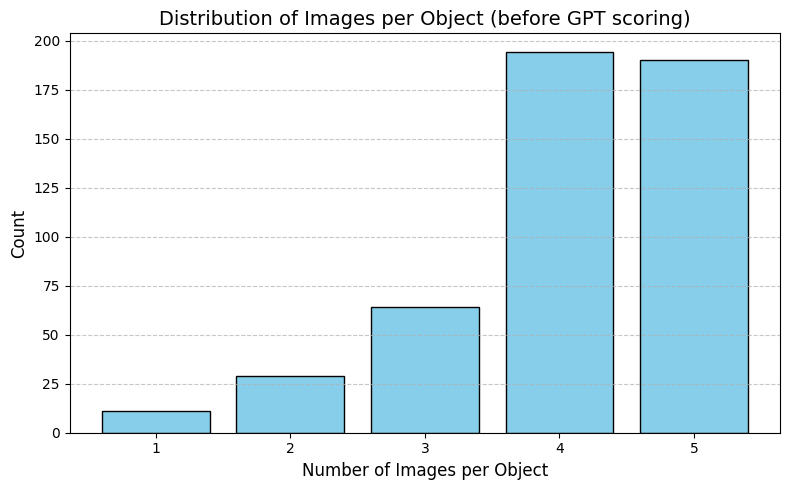

In [14]:
# Compute stats
per_object, distribution = compute_dataset_stats(df_expanded, object_col="object", path_col="image_path")

# Plot
plot_distribution(distribution, title="Distribution of Images per Object (before GPT scoring)")

In [21]:
df_expanded

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response
0,['green'],brown,American chameleon,https://media.istockphoto.com/id/1233284953/ve...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
1,['green'],brown,American chameleon,https://www.shutterstock.com/image-vector/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
2,['white'],orange,Arctic fox,https://img.stablecog.com/insecure/1920w/aHR0c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
3,['white'],orange,Arctic fox,https://cdn.vectorstock.com/i/1000v/88/70/arct...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
4,['white'],orange,Arctic fox,https://c8.alamy.com/comp/2PG76TD/fox-in-line-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
...,...,...,...,...,...,...
1982,['white'],orange,yurt,https://img.freepik.com/premium-vector/african...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
1983,['green'],orange,zucchini,https://thumbs.dreamstime.com/b/black-white-ou...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
1984,['green'],orange,zucchini,https://c8.alamy.com/comp/2RJ7GMM/hand-drawn-i...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None
1985,['green'],orange,zucchini,https://png.pngtree.com/png-vector/20221003/ou...,/mnt/lustre/work/eickhoff/esx061/color-concept...,None


In [22]:
# normalize all images to RGB and PNG format
def normalize_images_to_png(df, src_column="image_path", dst_column="norm_image_path"):
    new_paths = []

    for path in tqdm(df[src_column], desc="Normalizing images"):
        if path and os.path.exists(path):
            try:
                # Open and normalize (white background)
                img = Image.open(path).convert("RGBA")
                background = Image.new("RGBA", img.size, (255, 255, 255, 255))
                fixed = Image.alpha_composite(background, img).convert("RGB")

                # Keep base filename but force .png
                base = os.path.splitext(os.path.basename(path))[0]
                new_path = os.path.join(norm_images_folder, base + ".png")

                fixed.save(new_path, "PNG")
                new_paths.append(new_path)

            except Exception as e:
                print(f"Failed to process {path}: {e}")
                new_paths.append(None)
        else:
            new_paths.append(None)

    df[dst_column] = new_paths
    return df


df_expanded = normalize_images_to_png(df_expanded, src_column="image_path", dst_column="norm_image_path")
df_expanded.to_csv(expanded_path, index = False)

Normalizing images:   2%|▏         | 48/1987 [00:05<03:22,  9.58it/s]


KeyboardInterrupt: 

Displaying: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/American_chameleon_1_a069f782.png


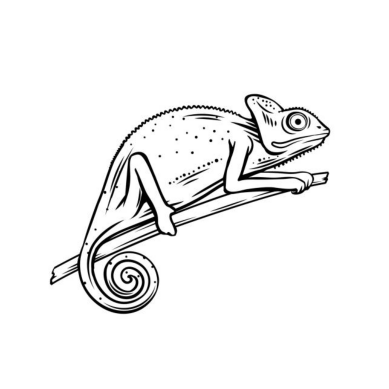

Displaying: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/American_chameleon_2_741ac6df.png


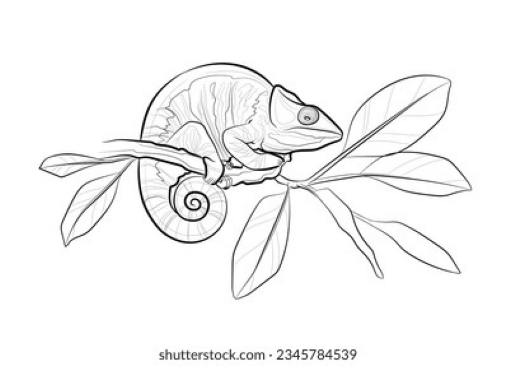

Displaying: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Arctic_fox_1_b0c1942c.png


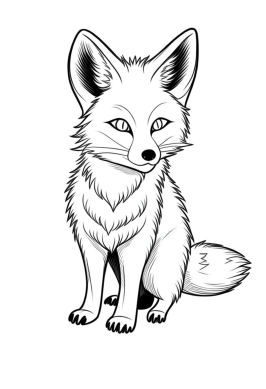

Displaying: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Arctic_fox_2_5cf07de2.png


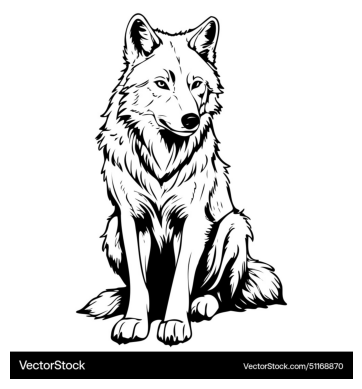

Displaying: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Arctic_fox_3_6334bd6e.png


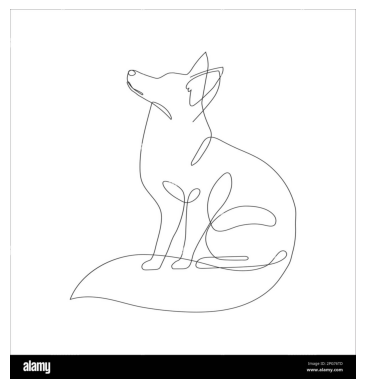

In [63]:
# Loop through the DataFrame and display each image
for i, row in df_expanded.head(5).iterrows():
    if row["image_path"]:  # Check if there is an image path
            image_path = f"{row['norm_image_path']}"
            print(f"Displaying: {image_path}")  # Print file name

            # Open and display the image
            try:
                image = Image.open(image_path)
                plt.figure()  # Create a new figure for each image
                plt.imshow(image)
                plt.axis("off")  # Hide axes
                #plt.title(f"{row['correct_answer']} {row['correct_object']} - Image {j+1}")  # Title with object, color, and number
                plt.show()  # Show the image
            except Exception as e:
                print(f"Error displaying {image_path}: {e}")


# 3. Analyse outline images with Chat GPT

In [13]:
df_expanded = pd.read_csv(expanded_path)

## 3.1. Query GPT

In [16]:
def parse_gpt_json(content):
    """
    Clean and parse JSON output from GPT, even if wrapped in code fences.
    """
    if not content:
        return {}

    # Remove markdown code fences like ```json ... ```
    cleaned = re.sub(r"^```(?:json)?\s*|\s*```$", "", content.strip(), flags=re.MULTILINE)

    try:
        return json.loads(cleaned)
    except json.JSONDecodeError:
        print("JSON parsing failed. Raw output:", content)
        return {"error": "invalid_json", "raw": content}


In [ ]:
# Define the function to query the GPT API for each image
# --- Retry wrapper for API calls ---
@retry(wait=wait_exponential(multiplier=2, min=4, max=60), stop=stop_after_attempt(3))
def evaluate_image_with_gpt(image_path, object_name, client, model_version="gpt-4o"):
    """
    Queries the GPT API to analyze the image and answer specific questions.
    """

    # Encode image to base64
    with open(image_path, "rb") as image_file:
        image_data = base64.b64encode(image_file.read()).decode("utf-8")

    # Structured prompt
    prompt = f"""
    You are analyzing a black-and-white outline drawing.
    Answer all questions in strict JSON only, with this schema:

    {{
      "white_background": "yes|no",
      "style": "illustration|realistic",
      "realism_score": 1-10,
      "watermark": "yes|no",
      "text_present": "yes|no",
      "objects": ["object1", "object2", "object3"],
      "is_target_object": "yes|no"
    }}

    The target object is: "{object_name}".
    """

    # Send request to GPT API
    response = client.chat.completions.create(
        model=model_version,
        messages=[
            {"role": "system", "content": "You are a strict JSON generator for image analysis tasks."},
            {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_data}"}}
            ]}
        ],
        max_tokens=500,
        temperature=0,
        top_p=0

    )

    content = response.choices[0].message.content.strip()
    return parse_gpt_json(content)

In [18]:
# Loop through each row in the expanded dataframe and query GPT API
def evaluate_dataset(df, client, checkpoint_path, start_idx=0, checkpoint_every=50):
  for i, row in tqdm(df_expanded.iterrows(), total=1987, desc="Evaluating images"):
      image_path = row["norm_image_path"]
      object_name = row["object"]

      try:
          gpt_response = evaluate_image_with_gpt(image_path, object_name, client)
          df.at[i, "gpt_response"] = gpt_response  # Store response in dataframe
      except Exception as e:
          df.at[i, "gpt_response"] = f"Error: {e}"  # Store error if any

  df.to_pickle(checkpoint_path)
  return df

In [8]:
API_KEY = os.environ["OPENAI_API_KEY"]

client = openai.OpenAI(api_key=API_KEY)

df_expanded = evaluate_dataset(
    df_expanded,
    client=client,
    checkpoint_path=checkpoint_path,
    start_idx=0,            # change if you want to resume later
    checkpoint_every=100     # adjust depending on runtime stability
)
df_expanded.to_csv(ranked_path, index = False)

NameError: name 'evaluate_dataset' is not defined

In [ ]:
# Code to resume evaluation if timeout occured
# Only run if needed

# Load checkpoint if it exists
"""if os.path.exists(checkpoint_path):
    df_expanded = pd.read_pickle(checkpoint_path)
    print(f"Loaded checkpoint from {checkpoint_path}")
else:
    print("No checkpoint found, starting fresh")

# Find the last processed row
if "gpt_response" in df_expanded:
    processed_mask = df_expanded["gpt_response"].notna()
    last_done = processed_mask[processed_mask].index.max() if processed_mask.any() else -1
    start_idx = last_done + 1
else:
    df_expanded["gpt_response"] = None
    start_idx = 0

print(f"Resuming from row {start_idx} of {len(df_expanded)}")

df_expanded = evaluate_dataset(
    df_expanded,
    client=client,
    checkpoint_path=checkpoint_path,
    start_idx=start_idx,   # resume from here
    checkpoint_every=50
)

df_expanded.to_csv(ranked_path, index = False)"""

'if os.path.exists(checkpoint_path):\n    df_expanded = pd.read_pickle(checkpoint_path)\n    print(f"Loaded checkpoint from {checkpoint_path}")\nelse:\n    print("No checkpoint found, starting fresh")\n\n# Find the last processed row\nif "gpt_response" in df_expanded:\n    processed_mask = df_expanded["gpt_response"].notna()\n    last_done = processed_mask[processed_mask].index.max() if processed_mask.any() else -1\n    start_idx = last_done + 1\nelse:\n    df_expanded["gpt_response"] = None\n    start_idx = 0\n\nprint(f"Resuming from row {start_idx} of {len(df_expanded)}")\n\ndf_expanded = evaluate_dataset(\n    df_expanded,\n    client=client,\n    checkpoint_path=checkpoint_path,\n    start_idx=start_idx,   # resume from here\n    checkpoint_every=50\n)\n\ndf_expanded.to_csv(ranked_path, index = False)'

## 3.2. Score outline images from GPT responses

In [14]:
df_ranked = pd.read_csv(ranked_path)
df_ranked["image_path"] = df_ranked["norm_image_path"]
df_ranked = df_ranked.drop(columns=["norm_image_path"])

In [15]:
df_ranked

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score
0,['green'],brown,American chameleon,https://media.istockphoto.com/id/1233284953/ve...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0
1,['green'],brown,American chameleon,https://www.shutterstock.com/image-vector/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0
2,['white'],orange,Arctic fox,https://img.stablecog.com/insecure/1920w/aHR0c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",48
3,['white'],orange,Arctic fox,https://cdn.vectorstock.com/i/1000v/88/70/arct...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0
4,['white'],orange,Arctic fox,https://c8.alamy.com/comp/2PG76TD/fox-in-line-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",28
...,...,...,...,...,...,...,...
1982,['white'],orange,yurt,https://img.freepik.com/premium-vector/african...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0
1983,['green'],orange,zucchini,https://thumbs.dreamstime.com/b/black-white-ou...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0
1984,['green'],orange,zucchini,https://c8.alamy.com/comp/2RJ7GMM/hand-drawn-i...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0
1985,['green'],orange,zucchini,https://png.pngtree.com/png-vector/20221003/ou...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0


In [16]:
# Function to calculate score based on GPT response
def calculate_score(response, object_name, per_extra_penalty=3):
    """
    Calculates the score based on the structured JSON GPT response with soft penalty for extra objects.
    Expected schema:
    {
      "white_background": "yes|no",
      "style": "illustration|realistic",
      "realism_score": 1-10,
      "watermark": "yes|no",
      "text_present": "yes|no",
      "objects": ["object1", ...],
      "is_target_object": "yes|no"
    }
    """

    max_score = 50

    if isinstance(response, dict):
        parsed = response

    elif isinstance(response, str):
        # if it's an error message
        if response.strip().lower().startswith("error"):
            print(f"Skipping error response: {response}")
            return np.nan

        try:
            parsed = json.loads(response)
        except json.JSONDecodeError:
            try:
                parsed = ast.literal_eval(response)
            except Exception as e:
                print(f"Could not parse response string: {response} ({e})")
                return 0
    else:
        print(f"Invalid response type: {type(response)}")
        return 0

    if not isinstance(parsed, dict):
        print(f"Parsed object is not a dict: {parsed}")
        return 0

     # Check target object
    is_target = parsed.get("is_target_object", "").lower() == "yes"
    objects = [o.lower() for o in parsed.get("objects", []) if isinstance(o, str)]
    num_objects = len(objects)
    in_list = object_name.lower() in objects

    # Calculate score
    score = 0

    # Q1: white background
    if parsed.get("white_background", "").lower() == "yes":
        score += 10
    elif "white_background" not in parsed:
        print(f"Missing key 'white_background' in response: {parsed}")

    # Q2: style (illustration vs realistic)
    if parsed.get("style", "").lower() == "illustration":
        score += 10
    elif "style" not in parsed:
        print(f"Missing key 'style' in response: {parsed}")

    # Q3: realism score
    try:
        realism = int(parsed.get("realism_score", 0))
        score += realism
    except (ValueError, TypeError):
        print(f"Invalid realism_score: {parsed.get('realism_score')}")

    # Q4: watermark
    if "watermark" not in parsed:
        print(f"Missing key 'watermark' in response: {parsed}")
    else:
        watermark_flag = True
        watermark = parsed.get("watermark", "").lower()

        if watermark == "no":
            score += 10
            watermark_flag = False

    # Q5: text_present
    if parsed.get("text_present", "").lower() == "no":
        score += 10
    elif "text_present" not in parsed:
        print(f"Missing key 'text_present' in response: {parsed}")

    # Q6: objects
    extra = max(0, len(objects) - 1)
    score = max(0, min(max_score, score - extra * per_extra_penalty))

    return score, watermark_flag, num_objects, (is_target or in_list)


# Apply scoring function to the GPT response column
df_ranked[["score", "watermark", "num_objects", "target_present"]] = df_ranked.progress_apply(lambda row: pd.Series(calculate_score(row["gpt_response"], row["object"], per_extra_penalty=3)), axis=1)

100%|██████████| 1987/1987 [00:00<00:00, 7722.37it/s]

Skipping error response: Error: RetryError[<Future at 0x7e4dd8c68ec0 state=finished raised TypeError>]
Skipping error response: Error: RetryError[<Future at 0x7e4dd8b1af00 state=finished raised TypeError>]


,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,target_present
1347,['green'],pink,pickle,https://www.onlygfx.com/wp-content/uploads/202...,NaN,Error: RetryError[<Future at 0x7e4dd8c68ec0 st...,NaN,NaN,NaN,NaN
1524,"['brown', 'black']",blue,ringlet,https://upload.wikimedia.org/wikipedia/commons...,NaN,Error: RetryError[<Future at 0x7e4dd8b1af00 st...,NaN,NaN,NaN,NaN


Failed image urls: 1347    https://www.onlygfx.com/wp-content/uploads/202...
1524    https://upload.wikimedia.org/wikipedia/commons...
Name: image_url, dtype: object

Removed 2 errors

===== Dataset Statistics =====
Total objects: 488
Total unique paths: 1985
Total images (sum over objects): 1985

===== Distribution of Images per Object =====


/tmp/ipykernel_807882/4167429358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ranked["target_present"] = df_ranked["target_present"].astype("boolean")


,num_objects,count
0,1,11
1,2,29
2,3,65
3,4,194
4,5,189


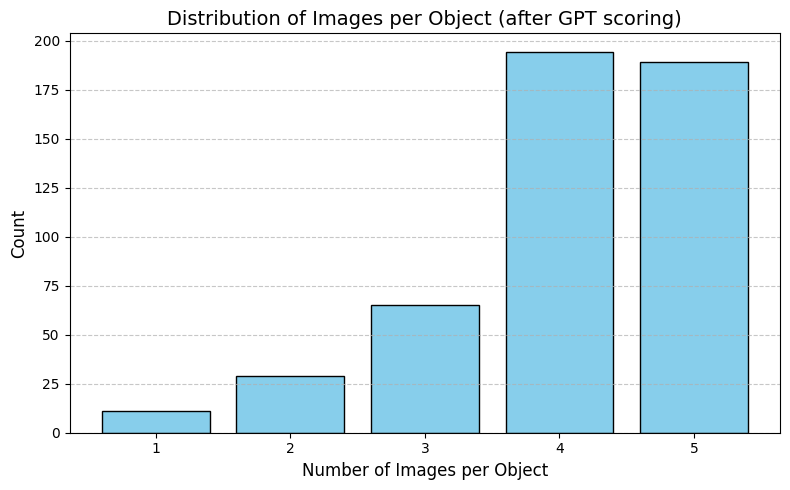

In [17]:
# Find and remove errors from GPT rating
errors = pd.to_numeric(df_ranked["score"], errors="coerce").isna()
display(df_ranked[errors])
print(f"Failed image urls: {df_ranked['image_url'][errors]}")
df_ranked = df_ranked[~errors]
df_ranked["target_present"] = df_ranked["target_present"].astype("boolean")

print()
print("Removed {} errors".format(errors.sum()))
print()

# Compute stats
per_object_ranked, distribution_ranked = compute_dataset_stats(df_ranked, object_col="object", path_col="image_path")

# Plot
plot_distribution(distribution_ranked, title="Distribution of Images per Object (after GPT scoring)")

In [18]:
df_ranked

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,target_present
0,['green'],brown,American chameleon,https://media.istockphoto.com/id/1233284953/ve...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,2.0,False
1,['green'],brown,American chameleon,https://www.shutterstock.com/image-vector/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",19.0,True,3.0,False
2,['white'],orange,Arctic fox,https://img.stablecog.com/insecure/1920w/aHR0c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0,True
3,['white'],orange,Arctic fox,https://cdn.vectorstock.com/i/1000v/88/70/arct...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",25.0,True,1.0,False
4,['white'],orange,Arctic fox,https://c8.alamy.com/comp/2PG76TD/fox-in-line-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,True
...,...,...,...,...,...,...,...,...,...,...
1982,['white'],orange,yurt,https://img.freepik.com/premium-vector/african...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",43.0,False,1.0,True
1983,['green'],orange,zucchini,https://thumbs.dreamstime.com/b/black-white-ou...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",33.0,True,1.0,True
1984,['green'],orange,zucchini,https://c8.alamy.com/comp/2RJ7GMM/hand-drawn-i...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",19.0,True,3.0,True
1985,['green'],orange,zucchini,https://png.pngtree.com/png-vector/20221003/ou...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",31.0,True,2.0,True


## 3.3. Try soft-matching all images where target object was not detected

In [19]:
# Check how often target object wasn't recognized by GPT
print(f"Target object was not found in {df_ranked[~df_ranked['target_present']].shape[0]} images:")
df_ranked[~df_ranked["target_present"]]

Target object was not found in 286 images:


,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,target_present
0,['green'],brown,American chameleon,https://media.istockphoto.com/id/1233284953/ve...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,2.0,False
1,['green'],brown,American chameleon,https://www.shutterstock.com/image-vector/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",19.0,True,3.0,False
3,['white'],orange,Arctic fox,https://cdn.vectorstock.com/i/1000v/88/70/arct...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",25.0,True,1.0,False
13,"['brown', 'black']",green,Chesapeake Bay retriever,https://i.etsystatic.com/46353761/r/il/5b848b/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'no', 'style': 'illustrat...",20.0,False,2.0,False
25,"['red', 'orange', 'yellow', 'black']",blue,European fire salamander,https://thumbs.dreamstime.com/b/newt-salamande...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",33.0,True,1.0,False
...,...,...,...,...,...,...,...,...,...,...
1950,['green'],purple,wine bottle,https://i.pinimg.com/736x/af/1c/ef/af1cef10928...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",17.0,True,3.0,False
1951,['green'],purple,wine bottle,https://www.shutterstock.com/image-vector/hand...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",30.0,True,2.0,False
1955,['black'],yellow,wok,https://www.clipartmax.com/png/middle/320-3207...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'no', 'style': 'illustrat...",20.0,False,2.0,False
1956,['black'],yellow,wok,https://www.shutterstock.com/image-vector/flyi...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",38.0,False,3.0,False


In [20]:
# Simple normalizer
def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[^a-z\s]", "", name)  # keep only letters/spaces
    tokens = [t for t in name.split() if t not in {"american","common","european","wild","domestic","threetoed","twotoed","spotted","sulphur","vine","cabbage","green", "tow"}]
    return " ".join(tokens).strip()

def find_soft_matches(df, object_col="object", gpt_col="gpt_response", threshold=85):
    """
    Find cases where ground truth object is not an exact match
    but is close to one of the GPT detected objects.
    """

    soft_matches = []

    for i, row in df.iterrows():
        gt = normalize_name(row[object_col])
        gpt_objs = ast.literal_eval(row[gpt_col]).get("objects", [])

        # Normalize GPT objects too
        gpt_objs_norm = [normalize_name(o) for o in gpt_objs]

        # Check for fuzzy matches
        best_match, score, idx = process.extractOne(gt, gpt_objs_norm, scorer=fuzz.ratio) if gpt_objs_norm else (None, 0)

        if best_match and score >= threshold:
            soft_matches.append({
                "index": i,
                "ground_truth": row[object_col],
                "normalized_gt": gt,
                "gpt_objects": gpt_objs,
                "best_match": best_match,
                "similarity": round(score, 2),
                "image_path": row["image_path"]
            })

    return pd.DataFrame(soft_matches)


In [21]:
threshold = 85
soft_matches_df = find_soft_matches(df_ranked.loc[~df_ranked["target_present"]], object_col="object", gpt_col="gpt_response", threshold=threshold)
print(f"Soft-matches for similarity threshold of {threshold}%: {soft_matches_df.shape[0]}")
display(soft_matches_df)

Soft-matches for similarity threshold of 85%: 14


,index,ground_truth,normalized_gt,gpt_objects,best_match,similarity,image_path
0,0,American chameleon,chameleon,"[chameleon, branch]",chameleon,100.0,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,1,American chameleon,chameleon,"[chameleon, branch, leaves]",chameleon,100.0,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,416,cabbage butterfly,butterfly,[butterfly],butterfly,100.0,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,417,cabbage butterfly,butterfly,[butterfly],butterfly,100.0,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,889,green snake,snake,"[snake, branch, leaves]",snake,100.0,/mnt/lustre/work/eickhoff/esx061/color-concept...
5,891,green snake,snake,"[snake, branch, leaves]",snake,100.0,/mnt/lustre/work/eickhoff/esx061/color-concept...
6,892,green snake,snake,[snake],snake,100.0,/mnt/lustre/work/eickhoff/esx061/color-concept...
7,893,green snake,snake,[snake],snake,100.0,/mnt/lustre/work/eickhoff/esx061/color-concept...
8,1682,spotted salamander,salamander,[salamander],salamander,100.0,/mnt/lustre/work/eickhoff/esx061/color-concept...
9,1718,sulphur butterfly,butterfly,[butterfly],butterfly,100.0,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [22]:
# Add softmatched images to ranked_df
df_ranked.loc[soft_matches_df["index"], "target_present"] = True

# Set score to 0 where target object is not present
df_ranked.loc[~df_ranked["target_present"], "score"] = 0
df_ranked.drop(columns=["target_present"], inplace=True)

display(df_ranked)

/tmp/ipykernel_807882/1086608826.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ranked.drop(columns=["target_present"], inplace=True)


,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects
0,['green'],brown,American chameleon,https://media.istockphoto.com/id/1233284953/ve...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,2.0
1,['green'],brown,American chameleon,https://www.shutterstock.com/image-vector/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",19.0,True,3.0
2,['white'],orange,Arctic fox,https://img.stablecog.com/insecure/1920w/aHR0c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0
3,['white'],orange,Arctic fox,https://cdn.vectorstock.com/i/1000v/88/70/arct...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0.0,True,1.0
4,['white'],orange,Arctic fox,https://c8.alamy.com/comp/2PG76TD/fox-in-line-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0
...,...,...,...,...,...,...,...,...,...
1982,['white'],orange,yurt,https://img.freepik.com/premium-vector/african...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",43.0,False,1.0
1983,['green'],orange,zucchini,https://thumbs.dreamstime.com/b/black-white-ou...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",33.0,True,1.0
1984,['green'],orange,zucchini,https://c8.alamy.com/comp/2RJ7GMM/hand-drawn-i...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",19.0,True,3.0
1985,['green'],orange,zucchini,https://png.pngtree.com/png-vector/20221003/ou...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",31.0,True,2.0


## 3.4. Object count per image

In [30]:
def plot_num_objects_distribution(df, col="num_objects"):
    """
    Plot a pie chart of how many images have 1, 2, ... objects.
    Shows percentages in a legend instead of over the pie.
    """
    counts = df[col].value_counts().sort_index()
    labels = [f"{int(k)}" for k in counts.index]
    percentages = counts / counts.sum() * 100

    plt.figure(figsize=(6, 6))
    wedges, _ = plt.pie(
        counts,
        startangle=90,
        colors=plt.cm.Set3.colors
    )

    # Build legend labels with percentages
    legend_labels = [f"{lbl}: {pct:.1f}%" for lbl, pct in zip(labels, percentages)]

    plt.legend(
        wedges,
        legend_labels,
        title="Number of Objects",
        loc="center left",
        bbox_to_anchor=(1, 0.5)
    )

    plt.title("Distribution of Number of Objects per Image", fontsize=14)
    plt.tight_layout()
    plt.show()

    return counts

def top_objects_by_avg_num(df, object_col="object", num_col="num_objects", top_i=5):
    """
    Compute average num_objects per object and return top-i objects.
    """
    avg_per_object = (
        df.groupby(object_col)[num_col]
          .mean()
          .reset_index()
          .sort_values(num_col, ascending=False)
          .head(top_i)
          .rename(columns={num_col: "avg_num_objects"})
    )
    return round(avg_per_object, 2)

def num_objects_statistics(df, num_col="num_objects"):
    """
    Compute descriptive statistics for the number of objects per image.
    """
    stats = {
        "total_images": len(df),
        "max_num_objects": df[num_col].max(),
        "min_num_objects": df[num_col].min(),
        "mean_num_objects": df[num_col].mean(),
        "std_num_objects": df[num_col].std(),
        "images_with_single_object": (df[num_col] == 1).sum(),
        "images_with_multiple_objects": (df[num_col] > 1).sum(),
    }
    return stats

def display_images_for_objects(df, objects, path_col="image_path", max_per_object=3):
    """
    Display a few images for the given objects.
    """
    from IPython.display import display
    from PIL import Image

    for obj in objects:
        subset = df[df["object"] == obj].head(max_per_object)
        print(f"=== {obj} (showing {len(subset)} images) ===")
        for path in subset[path_col]:
            try:
                display(Image.open(path))
            except Exception as e:
                print(f"Could not load {path}: {e}")

===== Number of Objects Statistics =====
total_images: 1985
max_num_objects: 11.00
min_num_objects: 1.00
mean_num_objects: 1.82
std_num_objects: 1.19
images_with_single_object: 1114
images_with_multiple_objects: 871



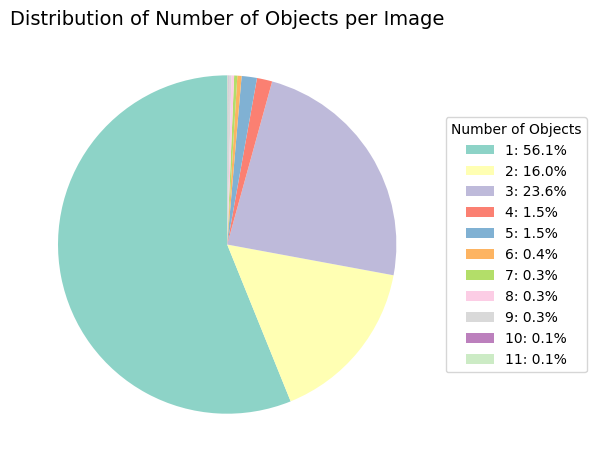

===== Top Objects by Avg Num_Objects =====


,object,avg_num_objects
183,fork,5.20
50,barn,4.40
137,computer keyboard,4.33
250,kuvasz,4.00
187,fridge,4.00
341,plunger,4.00
82,bowl,4.00
76,blackbird,3.80
415,stingray,3.75
186,freezer,3.75


In [100]:
stats_num = num_objects_statistics(df_ranked, num_col="num_objects")

print("===== Number of Objects Statistics =====")
for key, val in stats_num.items():
    print(f"{key}: {val:.2f}" if isinstance(val, float) else f"{key}: {val}")
print()

# Pie chart of number of objects in images
plot_num_objects_distribution(df_ranked, col="num_objects")

# Top-i objects
avg_top = top_objects_by_avg_num(df_ranked, object_col="object", num_col="num_objects", top_i=10)
print("===== Top Objects by Avg Num_Objects =====")
display(avg_top)

In [39]:
#display_images_for_objects(df_ranked, avg_top["object"].tolist(), path_col="image_path", max_per_object=3)

## 3.3. Best scoring images overall

In [50]:
def top_images_statistics(df, score_col="score", object_col="object", top_n=50):
    """
    Find top-N scored images overall and compute distribution + summary stats.
    Returns:
      - top_df: the top-N images
      - distribution: per-object counts
      - stats: summary dictionary with dataset statistics
    """
    # Select top-N overall
    top_df = df.sort_values(score_col, ascending=False).head(top_n)

    # Distribution of objects
    distribution = (
        top_df[object_col]
        .value_counts()
        .reset_index()
    )

    # Summary statistics
    stats = {
        "total_images": len(top_df),
        "unique_objects": top_df[object_col].nunique(),
        "best_score": top_df[score_col].max(),
        "worst_score": top_df[score_col].min(),
        "mean_score": top_df[score_col].mean(),
        "std_score": top_df[score_col].std()
    }

    return top_df, distribution, stats

def plot_object_frequency_in_topn(distribution, top_n=50):
    """
    Plot a pie chart of how many objects appear once, twice, etc.
    in the top-N images.

    distribution = dataframe with columns [object, count] from top_images_statistics
    """
    # Safely extract counts column
    if "count" in distribution.columns:
        counts = distribution["count"]
    else:
        counts = distribution.iloc[:, 1]

    # Frequency of "object appears k times"
    freq_counts = counts.value_counts().sort_index()

    # Pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        freq_counts,
        labels=[f"{k}× in top-{top_n}" for k in freq_counts.index],
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.Paired.colors
    )
    plt.title(f"Object Frequency Distribution in Top-{top_n} Images", fontsize=14)
    plt.show()

    return freq_counts

===== Top Images Statistics =====
Total images: 500
Unique objects: 307
Best score: 47
Worst score: 40
Mean score: 43.528 ± 1.633

===== Distribution of Top Images Across Objects =====


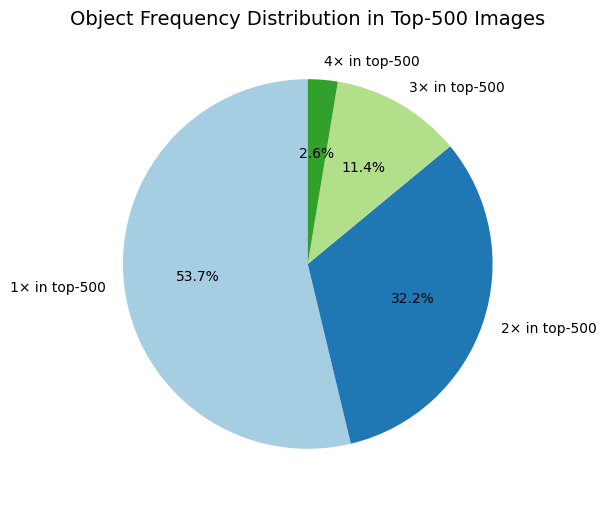

,object,count
0,Rottweiler,4
1,beetle,4
2,bear,4
3,ant,4
4,fox,4
5,steel arch bridge,4
6,mouse_(computer),4
7,tabby,4
8,chinese_lantern,3
9,cow,3


In [51]:
top_n = 500
top_df, top_distribution, stats = top_images_statistics(
    df_ranked, score_col="score", object_col="object", top_n=top_n
)

print("===== Top Images Statistics =====")
print(f"Total images: {stats['total_images']}")
print(f"Unique objects: {stats['unique_objects']}")
print(f"Best score: {stats['best_score']}")
print(f"Worst score: {stats['worst_score']}")
print(f"Mean score: {stats['mean_score']} ± {np.round(stats['std_score'], 3)}")

print("\n===== Distribution of Top Images Across Objects =====")
freq_counts = plot_object_frequency_in_topn(top_distribution, top_n=top_n)

top_objects = top_distribution.head(10)
display(top_objects)

## 3.3. Filter best k-images per object

In [51]:
def keep_best_k(
    df,
    k=1,
    max_num_objects=1,
    drop_na_num_objects=False,
):
    """
    Keep only the top-k scored images per object, AFTER filtering rows where
    num_objects <= max_num_objects. Returns a new dataframe.
    """
    # 1) filter by num_objects
    if drop_na_num_objects:
        eligible = df[df["num_objects"].notna()]
    else:
        eligible = df.copy()

    eligible = df[df["watermark"] != True].copy()
    eligible = eligible[eligible["num_objects"] <= max_num_objects]

    # 2) take top-k per object
    df_best_scores = (
        eligible.sort_values("score", ascending=False)
                .groupby("object", group_keys=False)
                .head(k)
                .reset_index(drop=True)
    )
    return df_best_scores


===== Best-k Images Dataset =====
k:1
Original dataset size: 1985
Reduced dataset size: 303
===== Dataset Statistics =====
Total objects: 303
Total unique paths: 303
Total images (sum over objects): 303

===== Distribution of Images per Object =====


,num_objects,count
0,1,303


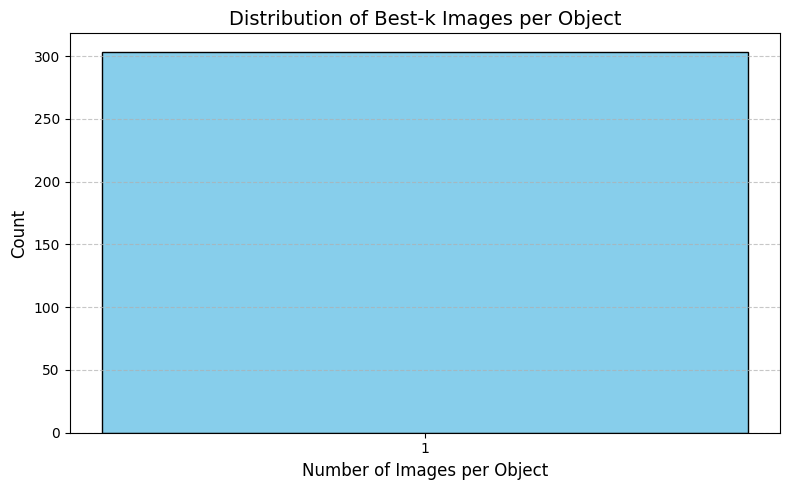

In [59]:
# Keep the best k images per object
k = 1
df_best_scores = keep_best_k(df_ranked, k=k, max_num_objects=1)

print(f"===== Best-k Images Dataset =====")
print(f"k:{k}")
print(f"Original dataset size: {len(df_ranked)}")
print(f"Reduced dataset size: {len(df_best_scores)}")

# Check distribution
per_object, distribution = compute_dataset_stats(df_best_scores, object_col="object", path_col="image_path")
plot_distribution(distribution, title="Distribution of Best-k Images per Object")

In [54]:
def plot_score_distribution_for_k_grouped(
    df, object_col="object", score_col="score", k_values=[1, 2, 3], max_score=50
):
    """
    For each k in k_values:
      - Keep top-k images per object
      - Compute average + std of scores
      - Plot grouped histogram (percentages)
    """
    stats = {}

    bins = np.arange(0, max_score + 5, 5)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    width = 1  # narrower bars for grouping

    plt.figure(figsize=(10, 6))

    for i, k in enumerate(k_values):
        # Top-k subset
        df_k = (
            df.sort_values(score_col, ascending=False)
              .groupby(object_col, group_keys=False)
              .head(k)
        )

        avg_score = df_k[score_col].mean()
        std_score = df_k[score_col].std()
        stats[k] = {"mean": avg_score, "std": std_score, "n": len(df_k)}

        counts, _ = np.histogram(df_k[score_col], bins=bins)
        counts = counts / counts.sum()  # Normalize

        # Shift bars for grouping
        plt.bar(
            bin_centers + (i - len(k_values) / 2) * width,
            counts,
            width=width,
            label=f"k={k} (mean={avg_score:.2f} ± {std_score:.2f})"
        )

    plt.title("Score Distribution for Different k (Grouped)", fontsize=14)
    plt.xlabel("Score", fontsize=12)
    plt.ylabel("Fraction of Images", fontsize=12)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    return stats

def plot_score_distribution_for_k_subplots(
    df, object_col="object", score_col="score", k_values=[1, 2, 3], max_score=50
):
    """
    For each k in k_values:
      - Keep top-k images per object
      - Compute average + std of scores
      - Plot histogram (percentages) in its own subplot
    """
    stats = {}

    fig, axes = plt.subplots(len(k_values), 1, figsize=(8, 4 * len(k_values)), sharex=True)

    if len(k_values) == 1:
        axes = [axes]  # make iterable

    bins = np.arange(0, max_score + 5, 5)

    for ax, k in zip(axes, k_values):
        df_k = (
            df.sort_values(score_col, ascending=False)
              .groupby(object_col, group_keys=False)
              .head(k)
        )

        avg_score = df_k[score_col].mean()
        std_score = df_k[score_col].std()
        stats[k] = {"mean": avg_score, "std": std_score, "n": len(df_k)}

        ax.hist(df_k[score_col], bins=bins, color="skyblue", edgecolor="black")
        ax.set_title(f"k={k} (mean={avg_score:.2f} ± {std_score:.2f})", fontsize=12)
        ax.set_ylabel("Count")

    axes[-1].set_xlabel("Score")
    plt.tight_layout()
    plt.show()

    return stats

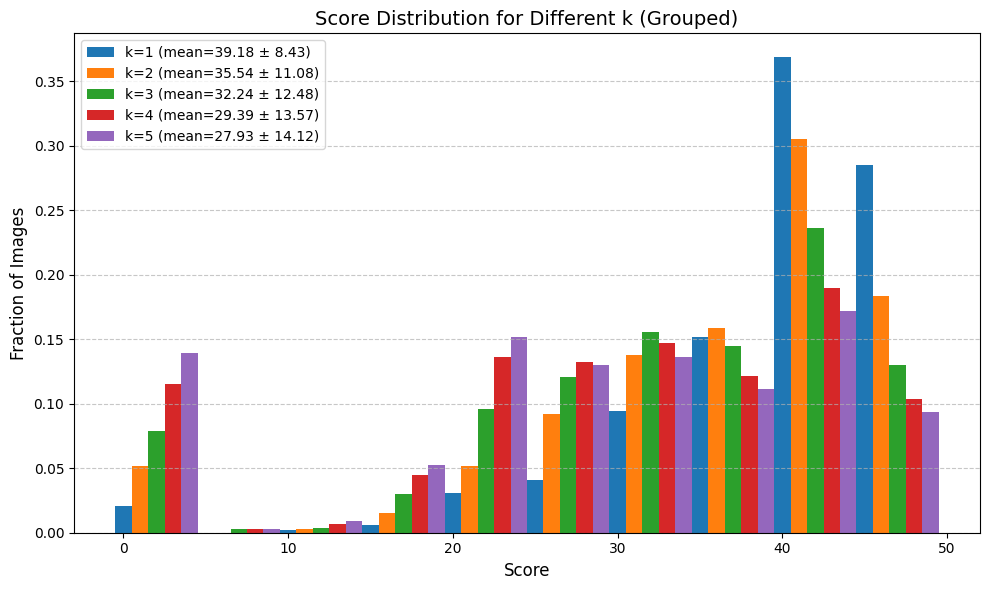

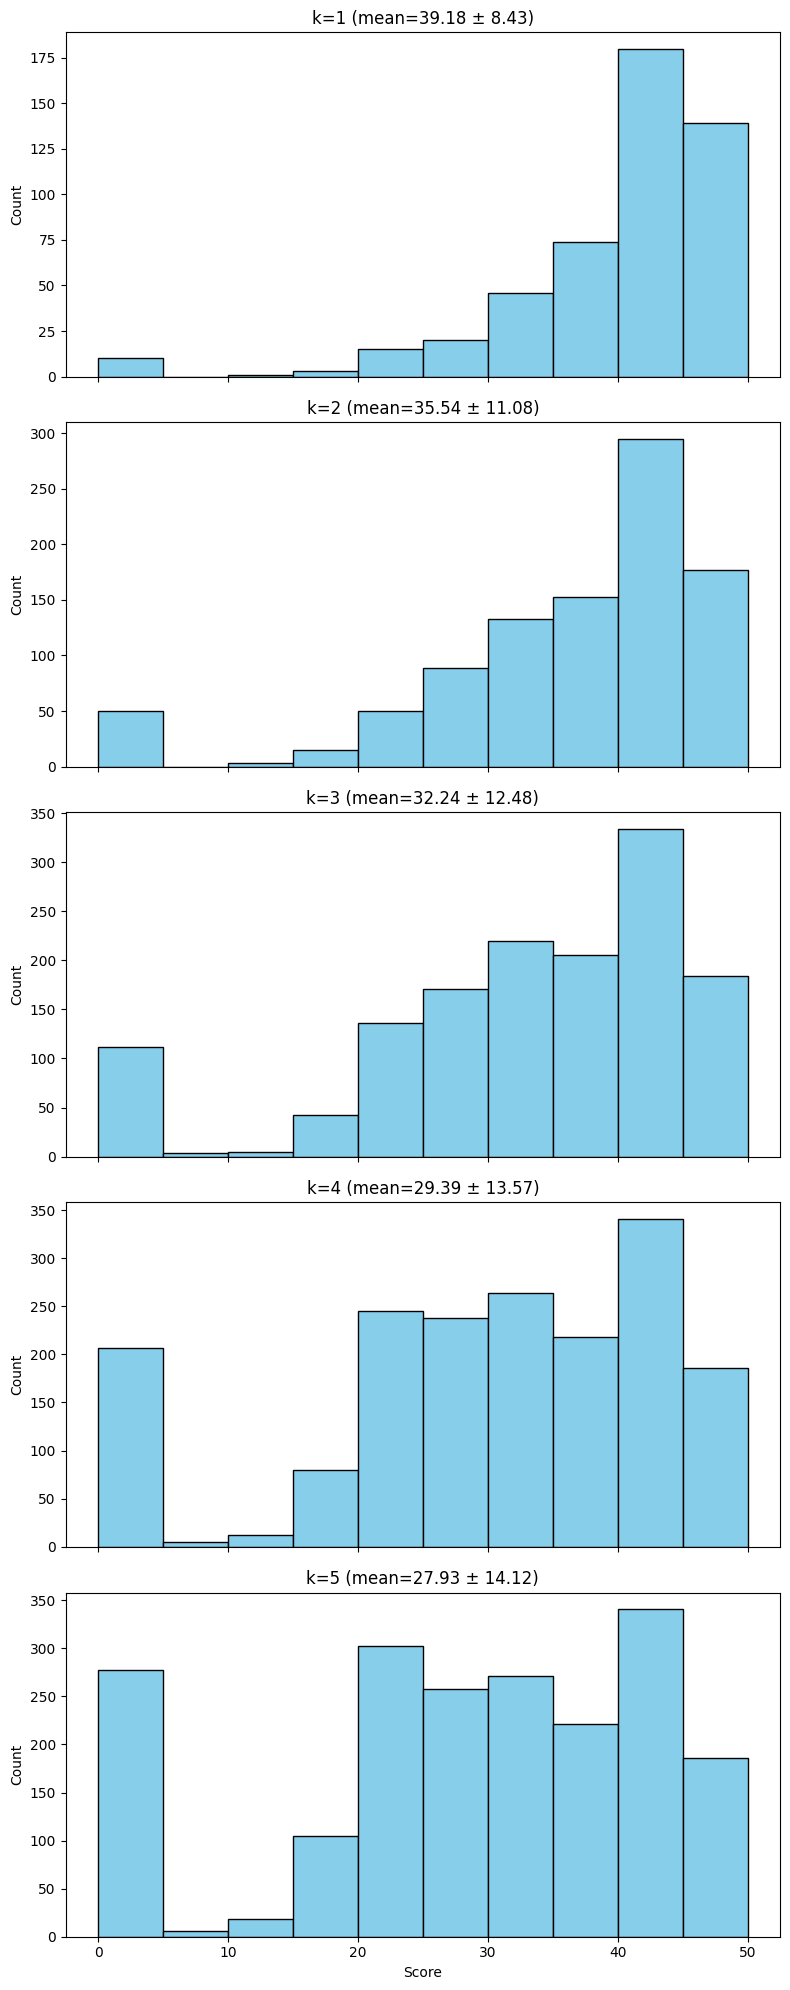

In [60]:
# Plot score distribution in different ways
avg_scores_grouped = plot_score_distribution_for_k_grouped(df_ranked, k_values=[1, 2, 3, 4, 5])

avg_scores_subplots = plot_score_distribution_for_k_subplots(df_ranked, k_values=[1, 2, 3, 4, 5])

In [61]:
df_best_scores

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects
0,['yellow'],purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
1,"['brown', 'black', 'orange']",green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
2,"['pink', 'white']",green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
...,...,...,...,...,...,...,...,...,...
298,"['black', 'grey']",red,Scottish deerhound,https://img.freepik.com/free-vector/hand-drawn...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0.0,False,1.0
299,"['black', 'brown', 'yellow', 'red']",yellow,spider,https://www.citypng.com/public/uploads/preview...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'no', 'style': 'illustrat...",0.0,False,1.0
300,['black'],pink,whip,https://img.freepik.com/premium-vector/simple-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0.0,False,1.0
301,['brown'],purple,whiskey jug,https://i.pinimg.com/564x/03/7f/6d/037f6dacd58...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",0.0,False,1.0


Displaying: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/celery_2_fe6842cb.png


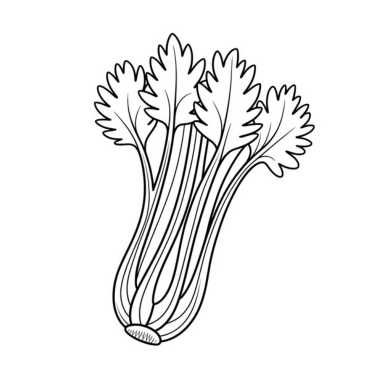

Displaying: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/toucan_1_41450e34.png


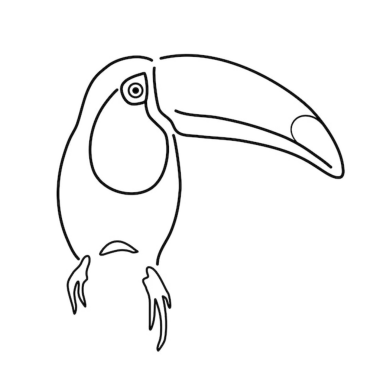

Displaying: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/kangaroo_1_ea795cb8.png


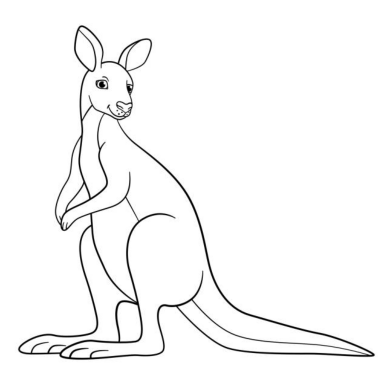

Displaying: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/yam_3_9d0eeb46.png


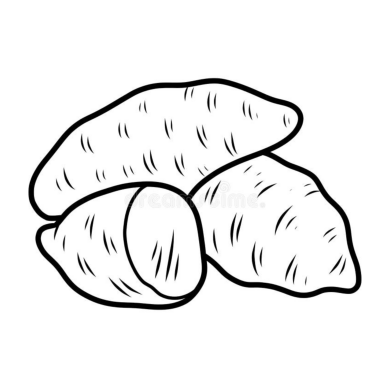

Displaying: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/raspberry_1_b2177d1c.png


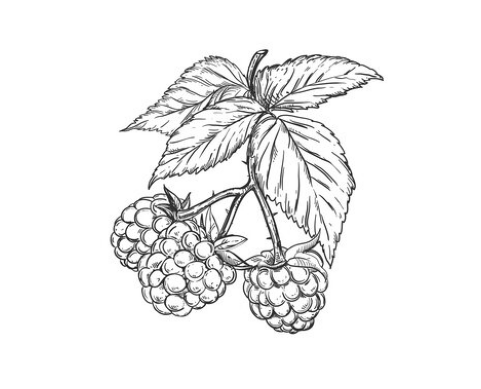

In [31]:
# Loop through the DataFrame and display each image
for i, row in df_best_scores.sample(5).iterrows():
    if row["image_path"]:  # Check if there is an image path
            image_path = f"{row['image_path']}"
            print(f"Displaying: {image_path}")  # Print file name

            # Open and display the image
            try:
                image = Image.open(image_path)
                plt.figure()  # Create a new figure for each image
                plt.imshow(image)
                plt.axis("off")  # Hide axes
                #plt.title(f"{row['correct_answer']} {row['correct_object']} - Image {j+1}")  # Title with object, color, and number
                plt.show()  # Show the image
            except Exception as e:
                print(f"Error displaying {image_path}: {e}")

In [64]:
df_final = keep_best_k(df_ranked, k=1, max_num_objects=1)
df_final = df_final[df_final["score"]!=0]
display(df_final)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects
0,['yellow'],purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
1,"['brown', 'black', 'orange']",green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
2,"['pink', 'white']",green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
...,...,...,...,...,...,...,...,...,...
266,['black'],pink,digital watch,https://img.freepik.com/premium-vector/digital...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",34.0,False,1.0
267,['black'],purple,raven,https://i.etsystatic.com/6063454/r/il/1b0913/6...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",33.0,False,1.0
268,"['brown', 'black']",red,cowboy boot,https://png.pngtree.com/png-clipart/20201216/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'no', 'style': 'illustrat...",33.0,False,1.0
269,"['yellow', 'red']",purple,tow truck,https://pics.coloringsai.com/tow-mater-colorin...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",33.0,False,1.0


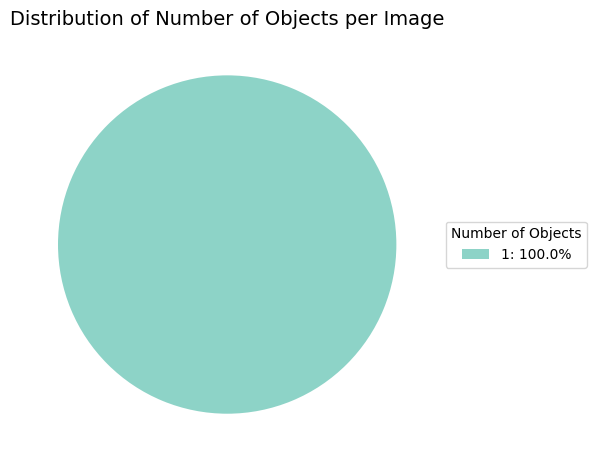

===== Top Objects by Avg Num_Objects =====


,object,avg_num_objects
0,Arctic fox,1.0
1,Band Aid,1.0
2,Chesapeake Bay retriever,1.0
3,Christmas stocking,1.0
4,Doberman,1.0
5,European fire salamander,1.0
6,French horn,1.0
7,French loaf,1.0
8,Gila monster,1.0
9,Gordon setter,1.0


In [112]:
# Pie chart of number of objects in images
plot_num_objects_distribution(df_final, col="num_objects")

# Top-i objects
avg_top = top_objects_by_avg_num(df_final, object_col="object", num_col="num_objects", top_i=10)
print("===== Top Objects by Avg Num_Objects =====")
display(avg_top)

In [ ]:
# Remove all images with more than max_obj objects
"""max_obj = 3
print(f"Removed {df_ranked[df_ranked['num_objects'] > 3].shape[0]} images with more than {max_obj} objects")
df_ranked = df_ranked[df_ranked["num_objects"] <= 3]
display(df_ranked)"""

'max_obj = 3\nprint(f"Removed {df_ranked[df_ranked[\'num_objects\'] > 3].shape[0]} images with more than {max_obj} objects")\ndf_ranked = df_ranked[df_ranked["num_objects"] <= 3]\ndisplay(df_ranked)'

## 3.4 Filter out some images by hand

In [ ]:
# Filer images by hand
s = 0
e = len(df_final)
#display_images_for_objects(df_final[s:e], df_final["object"].tolist()[s:e], path_col="image_path")

In [71]:
# List of objects to remove, curated by hand
bad_objects = [
    "Newfoundland",
    "seal",
    "black-and-tan coonhound",
    "steel arch bridge",
    "tennis ball",
    "Arctic fox",
    "water buffalo",
    "sailboat",
    "affenpinscher",
    "ox",
    "safety pin",
    "box",
    "buckeye",
    "mackerel",
    "maple_tree",
    "kuvasz",
    "chain",
    "chainlink fence",
    "goose",
    "platypus",
    "moose",
    "West Highland white terrier",
    "seagull",
    "sparrow",
    "flamingo",
    "chipmunk",
    "acorn squash",
    "yurt",
    "toucan",
    "beans",
    "raisin",
    "candle",
    "cabbage",
    "poppy",
    "porcupine",
    "pickle",
    "pumpkin",
    "ballpoint",
    "chain mail",
    "ladybug",
    "Weimaraner",
    "Gila monster",
    "raven",
    "space heater",
    "cowboy boot",
]

# Remove rows where object is in bad_objects
num_total = len(df_final)
df_final = df_final[~df_final["object"].isin(bad_objects)].copy()

num_removed = num_total - len(df_final)

print(f"Removed rows:   {num_removed}")
print(f"Remaining rows: {len(df_final)}")

Removed rows:   45
Remaining rows: 226


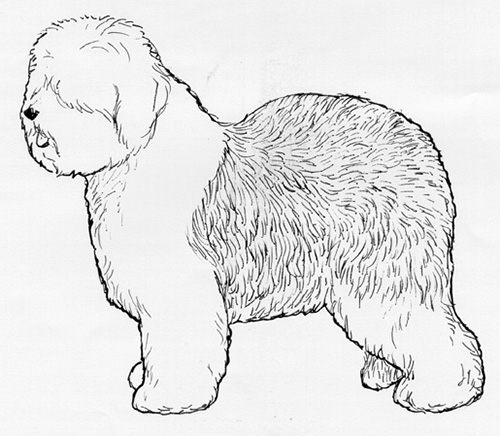

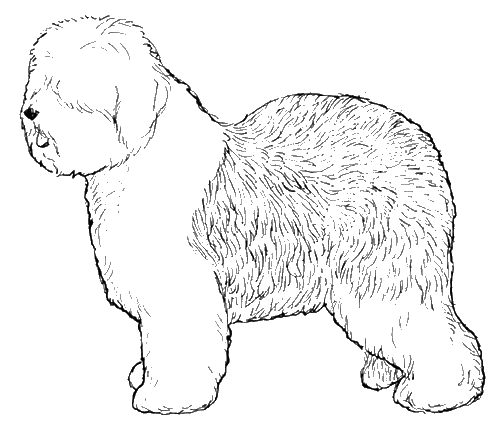

In [35]:
# Whiten background of one specific image
df_final = pd.read_csv(data_folder / "final_images.csv")

row = df_final["object"] == "Old English sheepdog"
path = df_final.loc[row, "image_path"].iloc[0]
img = Image.open(path).convert("RGB")
display(img)

arr = np.array(img)

# compute pixel brightness
brightness = arr.mean(axis=2)

# threshold: keep dark pixels, whiten everything else
BLACK_THRESHOLD = 170

mask_black = brightness < BLACK_THRESHOLD

# create white background
white = np.ones_like(arr) * 255

# keep black pixels, whiten rest
out = np.where(mask_black[..., None], arr, white)

out_img = Image.fromarray(out.astype(np.uint8))

display(out_img)
out_img.save(path)

In [36]:
# Safe dataframe with best k images
final_path = os.path.join(data_folder, "final_images.csv")
df_final.to_csv(final_path, index=False)

In [73]:
import numpy as np
# Define thresholds
black_threshold = 30  # RGB values ≤ 30 are considered black
black_ratio_threshold = 0.6  # 90% of the last row must be black
blue_color = (14, 119, 176)  # The specific blue color to detect
blue_tolerance = 30  # Allow some variation in blue detection
blue_ratio_threshold = 0.6  # 90% of the last row must be blue

# List to store images with black or blue in the last row
valid_images = []

for index, row in df_final.iterrows():
    image_path = row.get("norm_image_path")

    if not image_path:
        continue  # Skip if no image path is provided

    try:
        image = Image.open(image_path).convert("RGB")  # Convert to RGB
        image_array = np.array(image)

        # Get the last row of pixels
        last_row = image_array[-1, :, :]

        # Detect black pixels
        black_pixels = np.sum(np.all(last_row <= black_threshold, axis=1))

        # Detect blue pixels (within tolerance range)
        blue_pixels = np.sum(
            (np.abs(last_row[:, 0] - blue_color[0]) <= blue_tolerance) &
            (np.abs(last_row[:, 1] - blue_color[1]) <= blue_tolerance) &
            (np.abs(last_row[:, 2] - blue_color[2]) <= blue_tolerance)
        )

        total_pixels = last_row.shape[0]

        # Check if at least 90% of the last row is black or blue
        if (black_pixels / total_pixels >= black_ratio_threshold) or (blue_pixels / total_pixels >= blue_ratio_threshold):
            valid_images.append((image_path, image))  # Store path and image object

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Display valid images
if valid_images:
    for _, img in valid_images:
        display(img)
else:
    print("No images found with 90% black or blue pixels in the last row.")

# List to store cropped images with their paths
cropped_images = []

for image_path, image in valid_images:
    try:
        image_array = np.array(image)

        # Identify rows that are mostly black (90% of pixels or more)
        black_rows = np.sum(np.all(image_array <= black_threshold, axis=2), axis=1) / image_array.shape[1] >= black_ratio_threshold

        # Identify rows that are mostly blue (90% of pixels within tolerance)
        blue_rows = np.sum(
            (np.abs(image_array[:, :, 0] - blue_color[0]) <= blue_tolerance) &
            (np.abs(image_array[:, :, 1] - blue_color[1]) <= blue_tolerance) &
            (np.abs(image_array[:, :, 2] - blue_color[2]) <= blue_tolerance),
            axis=1
        ) / image_array.shape[1] >= blue_ratio_threshold

        # Iterate from the bottom up to find the first non-black or non-blue row
        crop_end = image_array.shape[0]  # Default to full image height

        for i in range(image_array.shape[0] - 1, -1, -1):
            if black_rows[i]:  # If it's a black row, continue moving up
                continue
            elif blue_rows[i]:  # If it's a blue row, continue moving up
                continue
            else:
                crop_end = i + 1  # Stop cropping here
                break

        # Ensure we don't crop the entire image to zero height
        if crop_end <= 0:
            print(f"Skipping {image_path} to avoid empty image.")
            cropped_images.append((image_path, image))
            continue

        # Crop the image from the top to the last valid row
        cropped_image = image.crop((0, 0, image.width, crop_end))

        cropped_images.append((image_path, cropped_image))

    except Exception as e:
        print(f"Error processing {image_path}: {e}")


No images found with 90% black or blue pixels in the last row.


In [74]:

# Display cropped images
if cropped_images:
    for _, img in cropped_images:
        display(img)
else:
    print("No images were cropped.")

# Save cropped images back to their original paths**
for image_path, cropped_image in cropped_images:
    try:
        cropped_image.save(image_path)
        print(f"Saved cropped image to {image_path}")
    except Exception as e:
        print(f"Error saving cropped image {image_path}: {e}")


No images were cropped.


In [75]:
df_final.to_csv(final_path, index=False)